In [1]:
#Adrian del Pozo Hernandez
#Ines Primo Lopez

import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as sg 
from tkinter import *
#import kbhit
# gráficos en el notebook
%matplotlib inline
SRATE = 44100 # Sample rate, para todo el programa
CHUNK = 1024

In [2]:
class Osc:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0,shape='sin'):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0
        self.shape = shape

    def next(self):    
        if self.shape=='sin':
            out = np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='square':
            out = sg.square(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='sawtooth':
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase)
        elif self.shape=='triangle':
            # Ojo, la triangular no existe como tal en scipy, pero podemos hacerla con dos sawtooth
            # el 2º parametro define la "rampa" la subida y bajada (ver documentacion)
            out = sg.sawtooth(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE+self.phase,0.5)
        self.frame += CHUNK

        return np.float32(self.amp*out)

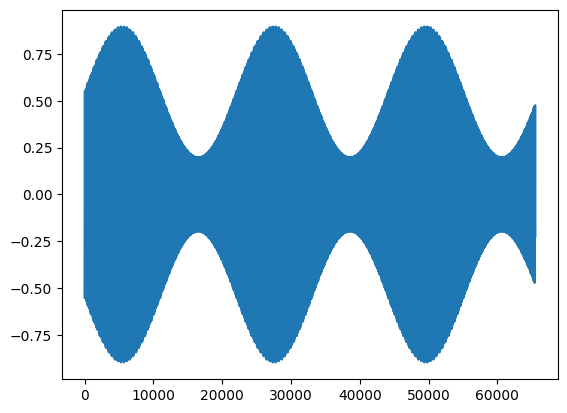

In [3]:
class Modulator:
    def __init__(self, signal, freq = 1, v0 = 0, v1 = 0):
        self.freq = freq
        self.v0 = v0
        self.v1 = v1
        self.signal = signal

        self.mod = Osc(self.freq)

        self.frame = 0
        

    def next(self):
        out = ((self.v1-self.v0)*self.mod.next()+(self.v1+self.v0))/2
        self.frame += CHUNK
        return out * self.signal.next()

# señal que vamos a modular
signal = Osc(freq=440,shape='triangle')

# con un modulador de 2 Hz y amplitud en [0.2,0.9]
mod = Modulator(signal,freq=2,v0=.2,v1=.9)

# generamos 1.5 segundos de señal modulada
time = 1.5
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

signal = np.empty(0) # acumulador de la señal

for i in range(chunks): # generamos los chunks
    signal = np.append(signal,mod.next())

plt.plot(signal)

sd.play(signal)

sd.wait()